In [243]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

## Functions

In [244]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [245]:
def plot_hist_normalized(this_column):
    pt = PowerTransformer()
    col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    sc = StandardScaler()
    col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")
    qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
    col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
    sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")

In [246]:
def boxplots_for_all_numerical_cols(this_df):
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [247]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [248]:
def all_numeric_to_int(this_df):
    for col in this_df._get_numeric_data():
        this_df[col] = this_df[col].astype(np.int64)


## Read and Clean

In [249]:
ca_df = pd.read_csv("C:/Users/roman/Documents/GitHub/Customer_Data_Analysis/Data/marketing_cust_analysis_round2.csv")
ca_df.columns

Index(['customer', 'state', 'customer_lifetime_value', 'response', 'coverage',
       'education', 'effective_to_date', 'employmentstatus', 'gender',
       'income', 'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'total_claim_amount',
       'vehicle_class', 'vehicle_size', 'vehicle_type', 'month'],
      dtype='object')

### Numerical columns

#### Boxplots

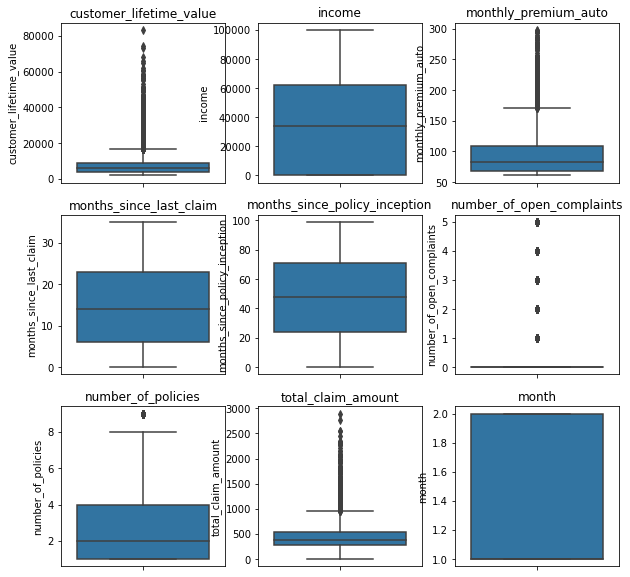

In [250]:
boxplots_for_all_numerical_cols(ca_df)

#### Check for NaNs

In [251]:
for col in split_column_names_by(ca_df)[0]:
    print(f"{col}: {ca_df[col].isna().sum()}")

customer_lifetime_value: 0
income: 0
monthly_premium_auto: 0
months_since_last_claim: 633
months_since_policy_inception: 0
number_of_open_complaints: 633
number_of_policies: 0
total_claim_amount: 0
month: 0


In [252]:
# ca_df["months_since_last_claim"].value_counts()

NaN will be replaced with mean of months_since_last_claim

In [253]:
ca_df["months_since_last_claim"].fillna(np.mean(ca_df["months_since_last_claim"]), inplace=True)

**Change appropriate numerical columns to categorical**

In [254]:
for col in ["number_of_open_complaints","number_of_policies", "month"]:
    ca_df[col] = ca_df[col].astype('category')

*placeholder*

**Categorical columns**

In [255]:
print(split_column_names_by(ca_df)[1])

['customer', 'state', 'response', 'coverage', 'education', 'effective_to_date', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


**drop some columns:**
+ customer → kind of primary key
+ effective to date → does not seem to have an effect for the model

In [256]:
ca_df.drop(["customer", "effective_to_date"], axis=1, inplace=True)

In [257]:
print(split_column_names_by(ca_df)[1])

['state', 'response', 'coverage', 'education', 'employmentstatus', 'gender', 'location_code', 'marital_status', 'number_of_open_complaints', 'number_of_policies', 'policy_type', 'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class', 'vehicle_size', 'vehicle_type', 'month']


In [260]:
ca_df["state"].value_counts()

California    3552
Oregon        2909
Arizona       1937
Nevada         993
Washington     888
Name: state, dtype: int64

## Findings

### No further adjustments

Error metrics **Test**:
+     R² = 0.744337
+ adj_R² = 0.740531

Error metrics **Train**:
+     R² = 0.740341
+ adj_R² = 0.736475

### Drop all income 0 rows

`ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]`

Error metrics **Test**:
+     R² = 0.759750
+ adj_R² = 0.755024

Error metrics **Train**:
+     R² = 0.767118
+ adj_R² = 0.762536

### Income 0 replaced with mean (excluding the 0's for the calculation of the mean)

`ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df_adj[ca_df["income"] != 0]["income"]))`

Error metrics **Test**:
+     R² = 0.744460
+ adj_R² = 0.740655

Error metrics **Train**:
+     R² = 0.740280
+ adj_R² = 0.736413

### next step

Error metrics **Test**:
+     R² = 
+ adj_R² = 

Error metrics **Train**:
+     R² = 
+ adj_R² = 

### next step

Error metrics **Test**:
+     R² = 
+ adj_R² = 

Error metrics **Train**:
+     R² = 
+ adj_R² = 

### next step

Error metrics **Test**:
+     R² = 
+ adj_R² = 

Error metrics **Train**:
+     R² = 
+ adj_R² = 

## Adjust the DataFrame to finetune the model

### Dataframe set up

In [202]:
ca_df_adj = ca_df

In [203]:
ca_df_adj = ca_df_adj[ca_df_adj["income"] != 0]

In [204]:
len(ca_df_adj)

8123

In [205]:
# from scipy import stats
# ca_df_adj = ca_df_adj[(np.abs(stats.zscore(ca_df_adj["monthly_premium_auto"])) < 3)]
# ca_df_adj

In [206]:
ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df[ca_df["income"] != 0]["income"]))

C:\Users\roman\AppData\Local\Temp/ipykernel_17880/2074025287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df_adj["income"] = ca_df_adj['income'].replace(0, np.mean(ca_df[ca_df["income"] != 0]["income"]))


#### Different transformations (zero income dropped)

##### Numerical

In [207]:
# boxplots_for_all_numerical_cols(split_df_by(ca_df_adj)[0])

In [208]:
# for col in split_column_names_by(ca_df_adj)[0]:
#     plot_hist_normalized(ca_df_adj[col])

In [209]:
qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
ca_df_adj["customer_lifetime_value_qt"] = qt.fit_transform(ca_df_adj["customer_lifetime_value"].to_numpy().reshape(-1,1))
ca_df_adj["income_qt"] = qt.fit_transform(ca_df_adj["income"].to_numpy().reshape(-1,1))
ca_df_adj["monthly_premium_auto_qt"] = qt.fit_transform(ca_df_adj["monthly_premium_auto"].to_numpy().reshape(-1,1))
ca_df_adj["months_since_last_claim_qt"] = qt.fit_transform(ca_df_adj["months_since_last_claim"].to_numpy().reshape(-1,1))
ca_df_adj["months_since_policy_inception_qt"] = qt.fit_transform(ca_df_adj["months_since_policy_inception"].to_numpy().reshape(-1,1))
ca_df_adj.drop(["income","customer_lifetime_value","monthly_premium_auto","months_since_last_claim","months_since_policy_inception"], axis=1, inplace=True)

C:\Users\roman\AppData\Local\Temp/ipykernel_17880/1839234149.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df_adj["customer_lifetime_value_qt"] = qt.fit_transform(ca_df_adj["customer_lifetime_value"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Temp/ipykernel_17880/1839234149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df_adj["income_qt"] = qt.fit_transform(ca_df_adj["income"].to_numpy().reshape(-1,1))
C:\Users\roman\AppData\Local\Temp/ipykernel_17880/1839234149.py:4: SettingWi

##### Categorical

In [210]:
categoricals_features= ca_df_adj.select_dtypes("object")
len(categoricals_features)

8123

In [211]:
# for col in categoricals_features.columns:
#     print(f"{col}:\n", categoricals_features[col].value_counts(),"\n  - - - - - -")

In [212]:
cat_cols=pd.get_dummies(categoricals_features, drop_first=True)

In [213]:
cat_cols

,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,coverage_Extended,coverage_Premium,education_College,education_Doctor,education_High School or Below,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,1,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
10903,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,0,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### X-y split

In [214]:
X=ca_df_adj.drop("total_claim_amount", axis=1)
y=ca_df_adj["total_claim_amount"]

In [215]:
X=X._get_numeric_data()
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt
0,-0.442432,-0.004804,-5.199338,-0.635580,0.118323
2,1.226274,-1.170743,0.402420,2.013252,-0.454737
3,1.624785,0.027116,0.332543,-0.383428,-1.785697
4,0.659579,-1.023183,1.026599,0.100636,-0.454737
5,-0.470810,0.063463,-5.199338,-1.358362,0.737330
...,...,...,...,...,...
10902,-0.820847,-0.680330,0.192060,-0.383428,-0.482771
10903,-1.206187,0.340674,-0.192060,1.315396,1.070111
10906,-0.235764,0.391770,-1.065669,-0.635580,0.575238
10907,1.717269,-0.231646,2.061689,-0.295601,0.432565


array([[<AxesSubplot:title={'center':'customer_lifetime_value_qt'}>,
        <AxesSubplot:title={'center':'income_qt'}>],
       [<AxesSubplot:title={'center':'monthly_premium_auto_qt'}>,
        <AxesSubplot:title={'center':'months_since_last_claim_qt'}>],
       [<AxesSubplot:title={'center':'months_since_policy_inception_qt'}>,
        <AxesSubplot:>]], dtype=object)

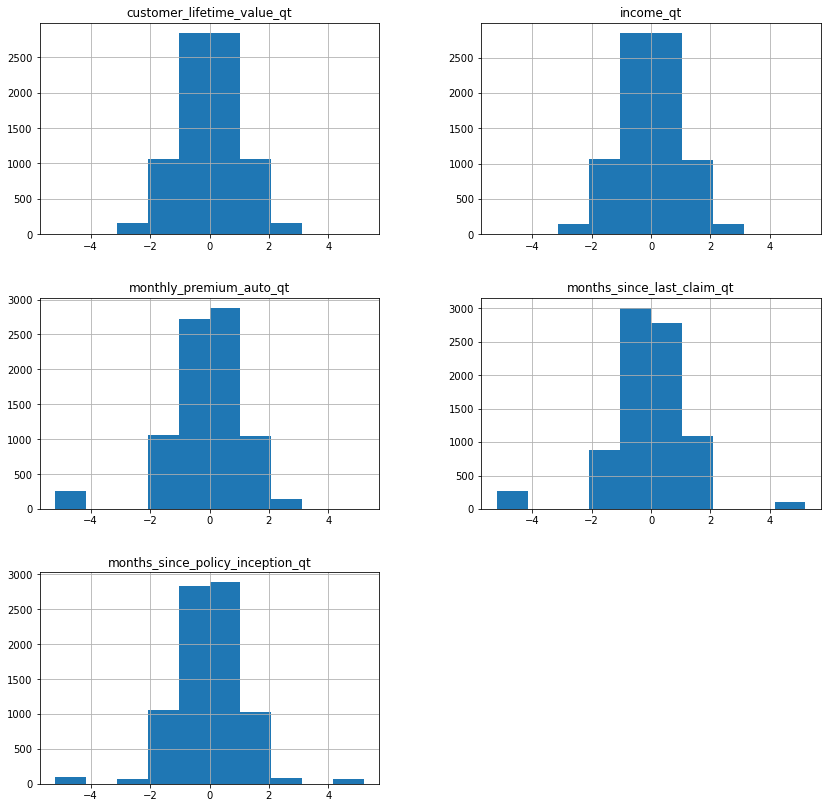

In [216]:
X.hist(figsize=(14,14))

**Concat dummies to numeric standardized**

In [217]:
X = pd.concat([X,cat_cols],axis=1)
X

,customer_lifetime_value_qt,income_qt,monthly_premium_auto_qt,months_since_last_claim_qt,months_since_policy_inception_qt,state_California,state_Nevada,state_Oregon,state_Washington,response_Yes,...,sales_channel_Branch,sales_channel_Call Center,sales_channel_Web,vehicle_class_Luxury Car,vehicle_class_Luxury SUV,vehicle_class_SUV,vehicle_class_Sports Car,vehicle_class_Two-Door Car,vehicle_size_Medsize,vehicle_size_Small
0,-0.442432,-0.004804,-5.199338,-0.635580,0.118323,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.226274,-1.170743,0.402420,2.013252,-0.454737,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
3,1.624785,0.027116,0.332543,-0.383428,-1.785697,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0.659579,-1.023183,1.026599,0.100636,-0.454737,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
5,-0.470810,0.063463,-5.199338,-1.358362,0.737330,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10902,-0.820847,-0.680330,0.192060,-0.383428,-0.482771,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10903,-1.206187,0.340674,-0.192060,1.315396,1.070111,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
10906,-0.235764,0.391770,-1.065669,-0.635580,0.575238,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10907,1.717269,-0.231646,2.061689,-0.295601,0.432565,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


#### Data splitting

In [218]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=42)

#### Standardize
+ Build scaling parameters on training set (mean variance) → more data as approx 80 % of sample <br>



In [219]:
std_scaler=StandardScaler().fit(X_train)

+ Apply on training set

In [220]:
X_train_scaled=std_scaler.transform(X_train)
# np.argwhere(np.isnan(X_train_scaled))

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [221]:
X_test_scaled=std_scaler.transform(X_test)

In [222]:
# print("X_train_scaled:")
# print(X_train_scaled)
# print("--------\nX_text_scaled:")
# print(X_test_scaled)

#### Modeling using Statsmodels

In [223]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     412.8
Date:                Wed, 02 Feb 2022   Prob (F-statistic):               0.00
Time:                        16:38:34   Log-Likelihood:                -35244.
No. Observations:                5686   AIC:                         7.058e+04
Df Residuals:                    5640   BIC:                         7.088e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.1056      1.585    237.927      0.0

In [224]:
predictions_test

array([435.53832878, 404.49460519, 524.03191398, ..., 172.57393804,
       226.27582729, 770.6778634 ])

In [225]:
#display adjusted R-squared
# print(model.rsquared_adj)

#### Modeling using Scikit Learn

##### Model fitting

In [226]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### Parameters of model

In [227]:
model.coef_

array([ 1.12162978e+01, -5.27998339e+00,  2.29337591e+01,  2.65765052e+00,
        3.38250320e+00,  1.31897215e+00,  1.33201403e+00,  2.57410679e+00,
        3.52172016e+00, -1.02814203e+00,  2.78797448e+01,  5.04662578e+01,
       -9.71802323e-01, -2.49598493e+00,  7.87602049e-01,  1.17237207e+00,
       -5.19598547e+00, -4.98907317e-01, -4.36935747e+00,  4.48960777e+00,
        1.90053147e+02,  9.25527338e+01, -2.64957588e+00,  3.02026152e+00,
        6.22529801e+13,  5.58336324e+13, -1.54983533e+00, -1.73191775e-01,
       -4.85476399e+13, -6.05072727e+13, -6.92268836e+13, -2.70480579e+13,
       -3.58257103e+13, -3.45575561e+13,  3.63823836e+00,  1.49163758e+00,
        2.98616093e+00, -1.02280006e+00, -1.41848545e+00,  2.11917069e+00,
        6.24264936e+01,  6.87922564e+01,  5.18914817e+01,  2.59947391e+01,
       -2.28858562e+00, -1.19323354e+01, -9.18574313e+00])

In [228]:
model.intercept_

377.09979582793926

In [229]:
model.score(X_test_scaled,y_test)

0.7597501479108774

##### Making prediction

In [230]:
y_pred=model.predict(X_test_scaled)

In [231]:
y_test

2625     389.636991
6302     497.047297
7355     527.139074
8803       5.746657
7944    1108.800000
           ...     
5157     114.815893
635      574.024018
2601      40.839965
5088     171.184016
1077     888.000000
Name: total_claim_amount, Length: 2437, dtype: float64

In [232]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### Plots

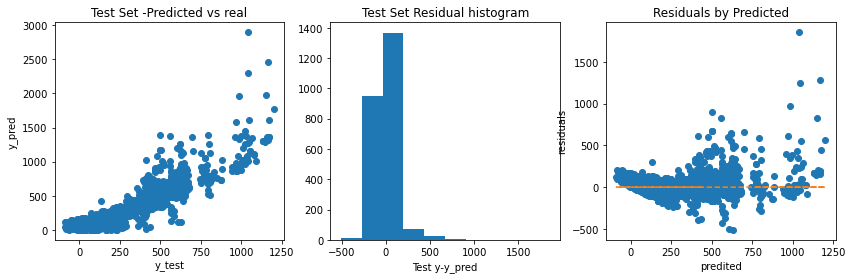

In [233]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predited")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

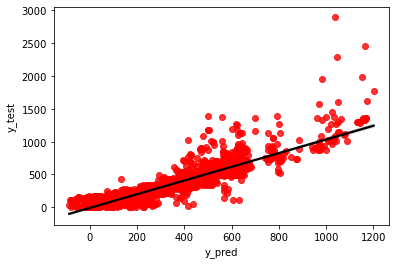

In [234]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

##### Error metrics Test

In [235]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

16716.337596014804
82.80288061449966


In [236]:
R2=r2_score(y_test,y_pred)
R2

0.7597501479108774

In [237]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.7550235915909993

##### Error metrics Train

In [238]:
y_pred=model.predict(X_train_scaled)

In [239]:
print(mse(y_train,y_pred))
print(mae(y_train,y_pred))

14168.297964188807
80.39638512897085


In [240]:
R2=r2_score(y_train,y_pred)
R2

0.7671175139176545

In [241]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

0.7625358994991236